In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [3]:
data_raw = pd.read_csv('desktop/AAPL.csv', index_col='Date')
data = generate_features(data_raw)

start_train = '1988-01-04'
end_train = '2017-12-31'

start_test = '2018-01-01'
end_test = '2018-12-31'


In [4]:
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

print(X_train.shape)
print(y_train.shape)


(7307, 37)
(7307,)


In [5]:
data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

print(X_test.shape)


(251, 37)


In [6]:
# First experiment with linear regression

scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

param_grid = {
    "alpha": [1e-4, 3e-4, 1e-3],
    "eta0": [0.01, 0.03, 0.1],
}
print(X_scaled_train)


[[-0.62591676 -0.62626615 -0.62605324 ... -0.3793764   0.36037055
  -0.69510113]
 [-0.62485737 -0.62584211 -0.62467505 ... -0.37850621  0.1549594
  -0.68199729]
 [-0.62464551 -0.62478191 -0.62446303 ...  0.51384046  0.36460632
  -0.54902188]
 ...
 [ 3.37598938  3.39572354  3.39026388 ...  0.01339645 -0.16228279
   0.36171045]
 [ 3.39734603  3.37910016  3.39097629 ... -0.62154246 -0.35722166
   0.3009561 ]
 [ 3.38595581  3.40047301  3.40237476 ... -0.44721115 -0.31731441
   0.28723795]]


In [7]:
from sklearn.linear_model import SGDRegressor
lr = SGDRegressor(penalty='l2', max_iter=1000, random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

{'alpha': 0.0001, 'eta0': 0.03}


In [8]:
lr_best = grid_search.best_estimator_

predictions_lr = lr_best.predict(X_scaled_test)

print(f'MSE: {mean_squared_error(y_test, predictions_lr):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions_lr):.3f}')
print(f'R^2: {r2_score(y_test, predictions_lr):.3f}')


MSE: 0.778
MAE: 0.690
R^2: 0.971


In [9]:
# Experiment with random forest

param_grid = {
    'max_depth': [30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5]

}


In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_features=10, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=10, n_estimators=10,
                                             n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [30, 50], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [11]:

print(grid_search.best_params_)
rf_best = grid_search.best_estimator_

predictions_rf = rf_best.predict(X_test)

{'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [12]:

print(f'MSE: {mean_squared_error(y_test, predictions_rf):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions_rf):.3f}')
print(f'R^2: {r2_score(y_test, predictions_rf):.3f}')


MSE: 60.826
MAE: 6.148
R^2: -1.304


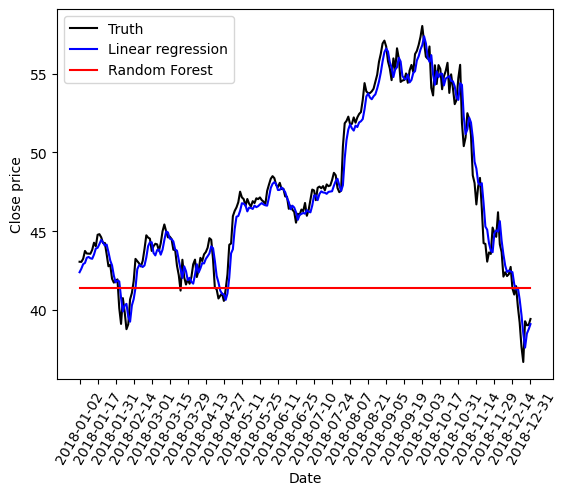

In [13]:

import matplotlib.pyplot as plt
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions_lr, c='b')
plt.plot(data_test.index, predictions_rf, c='r')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Linear regression', 'Random Forest'])
plt.show()